In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc
from IPython.display import clear_output
from collections import defaultdict
import os

from functools import lru_cache

def sum_2_tuples(a, b):
    return tuple(map(sum, zip(a, b)))

File paths:

In [69]:
TRADES_DIR = '../TRADES/USD_TOM_trades_Micex_02_10.feather'
LOB_DIR = '../Data_lob/'

SIGNATURE_FILE = './signature.db3'

TOXIC_BUY_MOMENTS_PATH = '../0_CommonFiles/toxic/toxic_buy_moments_1m_02_06.feather'
TOXIC_SELL_MOMENTS_PATH = '../0_CommonFiles/toxic/toxic_sell_moments_1m_02_06.feather'

TOXIC_SELL_SIGNATURE_PATH = '../0_CommonFiles/toxic/toxic_sign_sell.npy'
TOXIC_BUY_SIGNATURE_PATH = '../0_CommonFiles/toxic/toxic_sign.npy'

Experiment details:

In [52]:
# Signature hedger
volume = 1_000 # in contracts

look_back_time = np.timedelta64(30, 's')

hedge_params_df = pd.DataFrame({
    'zone_number': [1, 2, 3],
    'distance': [1, 5, 10],
    'proportion': [0.3, 0.2, 0.1]
})

# 1. Generate 1m trades of toxic client

In [7]:
trades = pd.read_feather(TRADES_DIR)
trades = trades[0:0]
trades

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE


In [9]:
toxic_buy_moments = pd.read_feather(TOXIC_BUY_MOMENTS_PATH)

In [10]:
toxic_buy_moments_2 = pd.DataFrame(index=toxic_buy_moments['Time']).between_time('10:00', '23:50')

In [11]:
toxic_buy_moments_2

""
Time
2021-02-01 10:01:36.771
2021-02-01 10:05:02.883
2021-02-01 10:05:11.061
2021-02-01 10:05:23.526
2021-02-01 10:07:27.929
...
2021-06-30 19:17:20.554
2021-06-30 19:30:16.189
2021-06-30 19:31:46.414


In [12]:
toxic_buy_moments_2_index = toxic_buy_moments_2.index

In [13]:
# https://stackoverflow.com/questions/43408621/add-a-row-at-top-in-pandas-dataframe
for mom in toxic_buy_moments_2_index:
    trades.loc[-1, ('Time', 'AGGRESSOR_SIDE', 'PRICE', 'SIZE', 'TRADE_VALUE')] = [mom, 'B', -1, 1000, -1000]
    trades.index = trades.index - 1

In [14]:
trades

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
-15683,2021-02-01 10:01:36.771,-1.0,1000.0,B,-1000.0
-15682,2021-02-01 10:05:02.883,-1.0,1000.0,B,-1000.0
-15681,2021-02-01 10:05:11.061,-1.0,1000.0,B,-1000.0
-15680,2021-02-01 10:05:23.526,-1.0,1000.0,B,-1000.0
-15679,2021-02-01 10:07:27.929,-1.0,1000.0,B,-1000.0
...,...,...,...,...,...
-6,2021-06-30 19:17:20.554,-1.0,1000.0,B,-1000.0
-5,2021-06-30 19:30:16.189,-1.0,1000.0,B,-1000.0
-4,2021-06-30 19:31:46.414,-1.0,1000.0,B,-1000.0
-3,2021-06-30 19:41:04.630,-1.0,1000.0,B,-1000.0


In [15]:
toxic_sell_moments = pd.read_feather(TOXIC_SELL_MOMENTS_PATH)

In [16]:
toxic_sell_moments_2 = pd.DataFrame(index=toxic_sell_moments['Time']).between_time('10:00', '23:50')

In [17]:
toxic_sell_moments_2

""
Time
2021-02-01 10:00:09.015
2021-02-01 10:04:36.332
2021-02-01 10:04:57.946
2021-02-01 10:05:19.015
2021-02-01 10:08:27.788
...
2021-06-30 19:03:41.640
2021-06-30 19:05:10.360
2021-06-30 19:05:24.713


In [18]:
toxic_sell_moments_2_index = toxic_sell_moments_2.index

In [19]:
# https://stackoverflow.com/questions/43408621/add-a-row-at-top-in-pandas-dataframe
for mom in toxic_sell_moments_2_index:
    trades.loc[-1, ('Time', 'AGGRESSOR_SIDE', 'PRICE', 'SIZE', 'TRADE_VALUE')] = [mom, 'S', -1, 1000, -1000]
    trades.index = trades.index - 1

In [20]:
trades.sort_values(by = 'Time', inplace=True)
trades.reset_index(drop = True, inplace=True)

In [21]:
trades

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
0,2021-02-01 10:00:09.015,-1.0,1000.0,S,-1000.0
1,2021-02-01 10:01:36.771,-1.0,1000.0,B,-1000.0
2,2021-02-01 10:04:36.332,-1.0,1000.0,S,-1000.0
3,2021-02-01 10:04:57.946,-1.0,1000.0,S,-1000.0
4,2021-02-01 10:05:02.883,-1.0,1000.0,B,-1000.0
...,...,...,...,...,...
31125,2021-06-30 19:30:16.189,-1.0,1000.0,B,-1000.0
31126,2021-06-30 19:31:46.414,-1.0,1000.0,B,-1000.0
31127,2021-06-30 19:40:36.010,-1.0,1000.0,S,-1000.0
31128,2021-06-30 19:41:04.630,-1.0,1000.0,B,-1000.0


# 2. Prepare signature (t0 + 1sec, t0 + 2 sec, ..., t0 + 30 sec)

In [40]:
arr_b = np.load(TOXIC_BUY_SIGNATURE_PATH)

In [41]:
arr_b

array([0.        , 0.00060652, 0.00076583, 0.00084845, 0.00092663,
       0.00097044, 0.00101048, 0.00105958, 0.00112067, 0.00118184,
       0.00122941, 0.00128676, 0.00131879, 0.00137308, 0.00138769,
       0.00141246, 0.00144499, 0.00147672, 0.00151539, 0.00154786,
       0.00155572, 0.00156564, 0.00157389, 0.00160786, 0.00162569,
       0.00163014, 0.00164679, 0.00167861, 0.00171992, 0.0017324 ,
       0.00174107, 0.00175855, 0.00178216, 0.00181039, 0.00186252,
       0.00188851, 0.00191741, 0.00190683, 0.00193289, 0.00198366,
       0.00200462, 0.00202701, 0.00205765, 0.00209319, 0.00213083,
       0.00215138, 0.00216443, 0.00218651, 0.00221448, 0.00221694,
       0.00222681, 0.00225959, 0.00225123, 0.00227095, 0.00229199,
       0.00229888, 0.00232601, 0.00232881, 0.00234191, 0.00235477,
       0.00240601, 0.0024529 , 0.00246497, 0.00248385, 0.00249143,
       0.00251261, 0.0025324 , 0.00254368, 0.00254669, 0.00253681,
       0.00257654, 0.00262445, 0.00263123, 0.00263597, 0.00262

In [43]:
arr_b = arr_b[::3]

In [44]:
arr_b = arr_b[1:31]

In [45]:
arr_b

array([0.00118184, 0.00151539, 0.00167861, 0.00191741, 0.00215138,
       0.00229199, 0.00248385, 0.00263123, 0.00277063, 0.00285221,
       0.00292325, 0.00303545, 0.00311994, 0.00316936, 0.00319025,
       0.00328976, 0.00342867, 0.00351475, 0.00354547, 0.00355494,
       0.00356097, 0.00366147, 0.0037261 , 0.00379613, 0.00385422,
       0.00397341, 0.00398439, 0.0039669 , 0.00403308])

In [46]:
arr_s = np.load(TOXIC_SELL_SIGNATURE_PATH)
arr_s = arr_s[::3]
arr_s = arr_s[1:31]
arr_s

array([-0.00103321, -0.00126052, -0.00144338, -0.00159671, -0.00169068,
       -0.00183257, -0.0020072 , -0.00211205, -0.00225794, -0.00236021,
       -0.00244329, -0.0025295 , -0.00264395, -0.00282395, -0.0029191 ,
       -0.00298147, -0.00300586, -0.00300877, -0.00307504, -0.00312307,
       -0.00319003, -0.00323405, -0.00331353, -0.00332765, -0.00339945,
       -0.00338945, -0.00344584, -0.00354666, -0.00357928, -0.00356825])

In [51]:
print({
    'B': {(1000, 1001): arr_b},
    'S': {(1000, 1001): arr_s}
    })

{'B': {(1000, 1001): array([0.00118184, 0.00151539, 0.00167861, 0.00191741, 0.00215138,
       0.00229199, 0.00248385, 0.00263123, 0.00277063, 0.00285221,
       0.00292325, 0.00303545, 0.00311994, 0.00316936, 0.00319025,
       0.00328976, 0.00342867, 0.00351475, 0.00354547, 0.00355494,
       0.00356097, 0.00366147, 0.0037261 , 0.00379613, 0.00385422,
       0.00397341, 0.00398439, 0.0039669 , 0.00403308])}, 'S': {(1000, 1001): array([-0.00103321, -0.00126052, -0.00144338, -0.00159671, -0.00169068,
       -0.00183257, -0.0020072 , -0.00211205, -0.00225794, -0.00236021,
       -0.00244329, -0.0025295 , -0.00264395, -0.00282395, -0.0029191 ,
       -0.00298147, -0.00300586, -0.00300877, -0.00307504, -0.00312307,
       -0.00319003, -0.00323405, -0.00331353, -0.00332765, -0.00339945,
       -0.00338945, -0.00344584, -0.00354666, -0.00357928, -0.00356825])}}


# 3. Build signature functions

In [54]:
signature_table = {
    'B': {
        # toxic signature
        (1000, 1001): [0.00084845, 0.00101048, 0.00118184, 0.00131879, 0.00141246,
       0.00151539, 0.00156564, 0.00162569, 0.00167861, 0.00174107,
       0.00181039, 0.00191741, 0.00198366, 0.00205765, 0.00215138,
       0.00221448, 0.00225959, 0.00229199, 0.00232881, 0.00240601,
       0.00248385, 0.0025324 , 0.00253681, 0.00263123, 0.00262157,
       0.00270485, 0.00277063, 0.00278913, 0.00280792, 0.00285221],
    },
    'S': {
        # toxic signature
        (1000, 1001): [-0.00103321, -0.00126052, -0.00144338, -0.00159671, -0.00169068,
       -0.00183257, -0.0020072 , -0.00211205, -0.00225794, -0.00236021,
       -0.00244329, -0.0025295 , -0.00264395, -0.00282395, -0.0029191 ,
       -0.00298147, -0.00300586, -0.00300877, -0.00307504, -0.00312307,
       -0.00319003, -0.00323405, -0.00331353, -0.00332765, -0.00339945,
       -0.00338945, -0.00344584, -0.00354666, -0.00357928, -0.00356825]
    }
}


def build_delta_signature(signature_table):
    output = {}
    for side in signature_table:
        if side not in output:
            output[side] = {}
        
        for size, array in signature_table[side].items():
            # for 1..N we store only delta - change from previous moment
            delta_signature = np.array(array[1:]) - np.array(array[:-1])
            
            '''
            for initial time T0 we store array[0],
            price jump before deal and after deal
            '''
            delta_signature = np.insert(delta_signature, obj=0, values=array[0]) 
            
            output[side][size] = delta_signature
            
    return output

delta_signature_table = build_delta_signature(signature_table)

In [53]:
def build_multitrades_signature(trades_before):
    signature = defaultdict(float)

    for trade in trades_before.itertuples():
        side = trade.AGGRESSOR_SIDE
        for size_range in signature_table[side]:
            if size_range[0] <= trade.SIZE <= size_range[1]:
                break

        delta_signature = delta_signature_table[side][size_range]

        times = {trade.Time + np.timedelta64(sec, 's') : delta_signature[sec] 
               for sec in range(30)}

        for k, v in times.items():
            signature[k] += v
        
    signature = (sorted(signature.items()))

    reconstructed_signature = []
    total = 0

    for (k,v) in signature:
        total += v
        reconstructed_signature.append((k, total))

    return reconstructed_signature

# 3. Hedge functions

In [55]:
def get_trades_before(moment):
    global look_back_time, trades
    moment_before = moment - look_back_time
    index1 = trades.Time.searchsorted(moment_before, side='left')
    index2 = trades.Time.searchsorted(moment, side='right')
    trades_before = trades.iloc[index1 : index2]
    return trades_before

In [56]:
'''
@returns 
zone1time - time, when zone1 ends and zone2 starts
zone2time - time, when zone2 ends and zone3 starts
'''
def get_zone_times(moment, side, skip_empty_trades = False):
    #1 get trades before our trade
    trades_before = get_trades_before(moment)
    
    if len(trades_before) == 0:
        if skip_empty_trades == False:
            #Columns: [Time, AGGRESSOR_SIDE, PRICE, SIZE, TRADE_VALUE]
            trades_before.loc[-1] = [moment, side, -1.0, 1000, -1000.0]  # adding a row
            trades_before.index = trades_before.index + 1  # shifting index
            trades_before = trades_before.sort_index()  # sorting by index
        else:
            return None, None

    #2 mix them into signature
    reference_signature = build_multitrades_signature(trades_before)
    #3 find three zones
    mmax = max(reference_signature, key = lambda item: item[1])
    mmin = min(reference_signature, key = lambda item: item[1])
    
    if side == 'B':
        zone1price = mmin[1] + (mmax[1] - mmin[1]) * 0.33
        zone2price = mmin[1] + (mmax[1] - mmin[1]) * 0.66
    
        for (k, v) in reference_signature:
            if v >= zone1price:
                #print(k)
                zone1time = k
                break
            
        for (k, v) in reference_signature:
            if v >= zone2price:
                #print(k)
                zone2time = k
                break
    else:
        zone1price = mmax[1] - (mmax[1] - mmin[1]) * 0.33
        zone2price = mmax[1] - (mmax[1] - mmin[1]) * 0.66
        
        for (k, v) in reference_signature:
            if v <= zone1price:
                #print(k)
                zone1time = k
                break
            
        for (k, v) in reference_signature:
            if v <= zone2price:
                #print(k)
                zone2time = k
                break
                
    #4 return result
    return zone1time, zone2time

In [57]:
def make_hedge(lob, datetime, size, side):
    #lob = lob[lob['Time'] >= datetime]
    time_index = lob['Time'].searchsorted(datetime, side='right')
        
    if time_index >= len(lob):
        return (0, 0.0)
    row = lob.iloc[time_index] # first timestamp >= datetime
    
    quote_side = 'BID' if (side == 'S') else 'ASK'
    
    maxsize = sum([row[quote_side + '_SIZE' + str(level)] for level in range(1, 11)])
        
    if maxsize < size:
        raise ValueError(f'size {size} is greater than available {maxsize}')
    
    size_hedged, sum_hedged = 0, 0.0
    level = 1
    while size_hedged < size and level < 11:
        portion = min(size - size_hedged, row[quote_side + '_SIZE' + str(level)])
        price = row[quote_side + '_PRICE' + str(level)]
        size_hedged += portion
        sum_hedged += portion * price
        print(f'added {portion} by {price}')
        level += 1
        
    print('HEDGE ended')
    return (size_hedged, sum_hedged)

In [60]:
class LOBCache:
    def __init__(self):
        pass
    
    def get_lob(self, datetime):
        #print(datetime)
        filename = datetime.strftime('LOB_%m%d.feather')
        return self.__get_lob_by_filename(filename)
        pass
    
    @lru_cache(maxsize=1)
    def __get_lob_by_filename(self, filename):
        print(filename)
        lob = pd.read_feather(LOB_DIR + filename).dropna()
        lob['BID_SIZE10'] = 99_999_999
        lob['ASK_SIZE10'] = 99_999_999
        return lob

In [61]:
cache = LOBCache()

In [62]:
def calc_hedge_signature(cache, moment, hedge_params_df):
    curr_moment = moment
    print(hedge_params_df)

    lob = cache.get_lob(curr_moment)
    remain = volume
    total = None
    
    zone1time, zone2time = get_zone_times(curr_moment, side, skip_empty_trades = True)
    print('zone1time, zone2time','\n',zone1time,'\n', zone2time)
    if zone1time is None:
        remain = 0
        total = (-2, -2.0)
    while remain > 0:
        print(curr_moment)
        
        # select our zone
        if moment <= curr_moment <= zone1time:
            print('we are in 1st zone')
            zone = 1
        elif zone1time < curr_moment <= zone2time:
            print('we are in 2nd zone')
            zone = 2
        else:
            print('we are in 3rd zone')
            zone = 3
        
        row = hedge_params_df[hedge_params_df['zone_number'] == zone]
        size_contracts = int(volume * row['proportion'])
        size_contracts = min(size_contracts, remain)

        hedge_result = make_hedge(lob, curr_moment, size = size_contracts, side = side)

        interval =  row['distance'].iloc[0]
        curr_moment = curr_moment + np.timedelta64(interval, 's')
        if hedge_result is None:
            break
        
        if hedge_result[0] == 0:
            return (-1, -1.0)
        
        if total is None:
            total = hedge_result
        else:
            total = sum_2_tuples(total, hedge_result)
            
        print(hedge_result)
        remain -= hedge_result[0]
        if remain == 0:
            break
            
    del lob
            
    if remain > 0:
        return None
    else:
        return total

# 5. Calculate and save results in DB

In [67]:
#CREATE TABLE RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));
sign_sql = sqlite3.connect(SIGNATURE_FILE)
sign_sql.execute('CREATE TABLE IF NOT EXISTS RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));')
cur=sign_sql.cursor()

In [80]:
records = []

for side in ('B', 'S'):
    if side == 'B':
        moments = toxic_buy_moments_2_index
    elif side == 'S':
        moments = toxic_sell_moments_2_index

    for moment in moments:
        record = (str(moment),side)
        query='select exists(select 1 from result where moment=? and side=? collate nocase) limit 1'
        # 'query' RETURNS 1 IF USERNAME EXISTS OR 0 IF NOT, AS INTEGER(MAYBE). 'collate nocase'= CASE INSENSITIVE, IT'S OPTIONAL
        check=cur.execute(query,record) 
        if check.fetchone()[0]==1:
            print(f'Moment already available ' + str(record))
            continue

        print('calculating for moment', moment)
        result = calc_hedge_signature(cache, moment, hedge_params_df)

        query='INSERT OR REPLACE INTO result(moment, side, quantity, sum) VALUES(?, ?, ?, ?);'
        if result:
            record = (str(moment), side, int(result[0]), result[1])
        else:
            record = (str(moment), side, -1, -1)

        print(record)
        cur.execute(query, record)
        records.append(record)

        gc.collect()

        if len(records) % 100 == 0:
            clear_output(wait=False)
        #break

calculating for moment 2021-06-30 15:17:00.774000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30 15:17:06.774000 
 2021-06-30 15:17:13.774000
2021-06-30 15:17:00.774000
we are in 1st zone
added 100 by 72.99
added 200 by 72.9875
HEDGE ended
(300, 21896.5)
2021-06-30 15:17:01.774000
we are in 1st zone
added 100 by 72.99
added 200 by 72.9875
HEDGE ended
(300, 21896.5)
2021-06-30 15:17:02.774000
we are in 1st zone
added 100 by 72.99
added 200 by 72.9875
HEDGE ended
(300, 21896.5)
2021-06-30 15:17:03.774000
we are in 1st zone
added 100 by 72.99
HEDGE ended
(100, 7298.999999999999)
('2021-06-30 15:17:00.774000', 'S', 1000, 72988.5)
calculating for moment 2021-06-30 15:19:21.173000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30

calculating for moment 2021-06-30 16:05:05.211000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30 16:05:11.211000 
 2021-06-30 16:05:18.211000
2021-06-30 16:05:05.211000
we are in 1st zone
added 300 by 72.86
HEDGE ended
(300, 21858.0)
2021-06-30 16:05:06.211000
we are in 1st zone
added 162 by 72.86
added 138 by 72.8575
HEDGE ended
(300, 21857.655)
2021-06-30 16:05:07.211000
we are in 1st zone
added 162 by 72.86
added 138 by 72.8575
HEDGE ended
(300, 21857.655)
2021-06-30 16:05:08.211000
we are in 1st zone
added 100 by 72.86
HEDGE ended
(100, 7286.0)
('2021-06-30 16:05:05.211000', 'S', 1000, 72859.31)
calculating for moment 2021-06-30 16:09:44.515000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30 16:09:50.515000 
 2021-06-

calculating for moment 2021-06-30 17:40:42.290000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30 17:40:48.290000 
 2021-06-30 17:40:55.290000
2021-06-30 17:40:42.290000
we are in 1st zone
added 50 by 72.905
added 150 by 72.9025
added 100 by 72.9
HEDGE ended
(300, 21870.625)
2021-06-30 17:40:43.290000
we are in 1st zone
added 100 by 72.905
added 150 by 72.9025
added 50 by 72.9
HEDGE ended
(300, 21870.875)
2021-06-30 17:40:44.290000
we are in 1st zone
added 300 by 72.905
HEDGE ended
(300, 21871.5)
2021-06-30 17:40:45.290000
we are in 1st zone
added 100 by 72.905
HEDGE ended
(100, 7290.5)
('2021-06-30 17:40:42.290000', 'S', 1000, 72903.5)
calculating for moment 2021-06-30 17:45:19.116000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 

calculating for moment 2021-06-30 18:18:42.935000
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-06-30 18:18:19.776000 
 2021-06-30 18:18:52.935000
2021-06-30 18:18:42.935000
we are in 2nd zone
added 200 by 73.065
HEDGE ended
(200, 14613.0)
2021-06-30 18:18:47.935000
we are in 2nd zone
added 101 by 73.06
added 99 by 73.0575
HEDGE ended
(200, 14611.7525)
2021-06-30 18:18:52.935000
we are in 2nd zone
added 100 by 73.06
added 100 by 73.0575
HEDGE ended
(200, 14611.75)
2021-06-30 18:18:57.935000
we are in 3rd zone
added 100 by 73.06
HEDGE ended
(100, 7306.0)
2021-06-30 18:19:07.935000
we are in 3rd zone
added 100 by 73.0575
HEDGE ended
(100, 7305.75)
2021-06-30 18:19:17.935000
we are in 3rd zone
added 100 by 73.055
HEDGE ended
(100, 7305.500000000001)
2021-06-30 18:19:27.935000
we are in 3rd zone
added 100 by 73.0525
HEDGE ended
(100, 7305.249999999999)
('2021-06

In [81]:
sign_sql.commit()

In [82]:
cur.close()
sign_sql.close()

# Temporary

Checking

Buying 10.000.000 at the moment '2021-04-07 17:40:30.455000'

In [83]:
moment = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:30.455000')

In [84]:
get_trades_before(moment)

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
15940,2021-04-07 17:40:30.455,-1.0,1000.0,B,-1000.0


In [85]:
get_zone_times(moment, side='B')

(Timestamp('2021-04-07 17:40:35.455000'),
 Timestamp('2021-04-07 17:40:45.455000'))

In [86]:
side = 'B'
calc_hedge_signature(cache, moment, hedge_params_df)

   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
LOB_0407.feather
zone1time, zone2time 
 2021-04-07 17:40:35.455000 
 2021-04-07 17:40:45.455000
2021-04-07 17:40:30.455000
we are in 1st zone
added 213 by 77.25
added 87 by 77.2525
HEDGE ended
(300, 23175.2175)
2021-04-07 17:40:31.455000
we are in 1st zone
added 300 by 77.2475
HEDGE ended
(300, 23174.25)
2021-04-07 17:40:32.455000
we are in 1st zone
added 300 by 77.2375
HEDGE ended
(300, 23171.25)
2021-04-07 17:40:33.455000
we are in 1st zone
added 50 by 77.24
added 50 by 77.2425
HEDGE ended
(100, 7724.125)


(1000, 77244.8425)

In [87]:
lob = cache.get_lob(moment)

In [88]:
signa = build_multitrades_signature(get_trades_before(moment))

In [89]:
sub_period = lob[lob.Time.between(moment - np.timedelta64(30, 's'), moment + np.timedelta64(120, 's'))]
sub_period

,Time,BID_PRICE1,BID_SIZE1,ASK_PRICE1,ASK_SIZE1,BID_PRICE2,BID_SIZE2,ASK_PRICE2,ASK_SIZE2,BID_PRICE3,...,ASK_PRICE8,ASK_SIZE8,BID_PRICE9,BID_SIZE9,ASK_PRICE9,ASK_SIZE9,BID_PRICE10,BID_SIZE10,ASK_PRICE10,ASK_SIZE10
2524808,2021-04-07 17:40:00.527288,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524809,2021-04-07 17:40:00.551957,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524810,2021-04-07 17:40:00.551957,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524811,2021-04-07 17:40:00.736204,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524812,2021-04-07 17:40:00.736216,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567960,2021-04-07 17:42:30.438736,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567961,2021-04-07 17:42:30.439176,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567962,2021-04-07 17:42:30.439176,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567963,2021-04-07 17:42:30.439183,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999


In [94]:
m1 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:30.455000')
p1 = 77.25
m2 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:31.455000')
p2 = 77.2475
m3 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:32.455000')
p3 = 77.2375
m4 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:33.455000')
p4 = 77.24

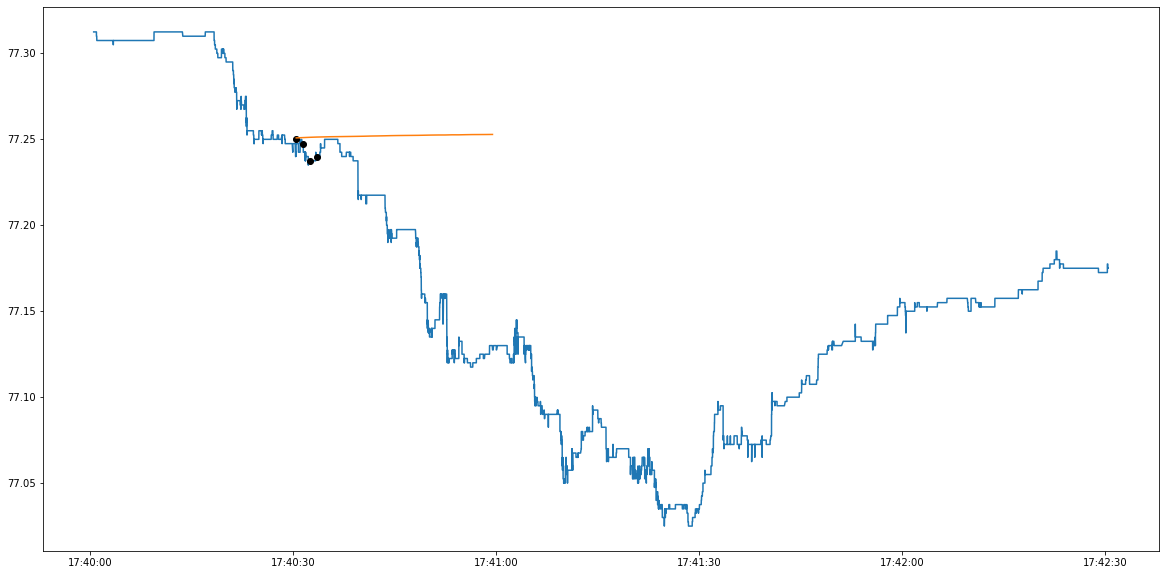

In [95]:
plt.figure(figsize=(20,10))
plt.plot(sub_period.Time, sub_period.ASK_PRICE1)
plt.plot(m1, p1,  'o', color='black')
plt.plot(m2, p2,  'o', color='black')
plt.plot(m3, p3,  'o', color='black')
plt.plot(m4, p4,  'o', color='black')
plt.plot([sig[0] for sig in signa], [77.25+sig[1] for sig in signa])

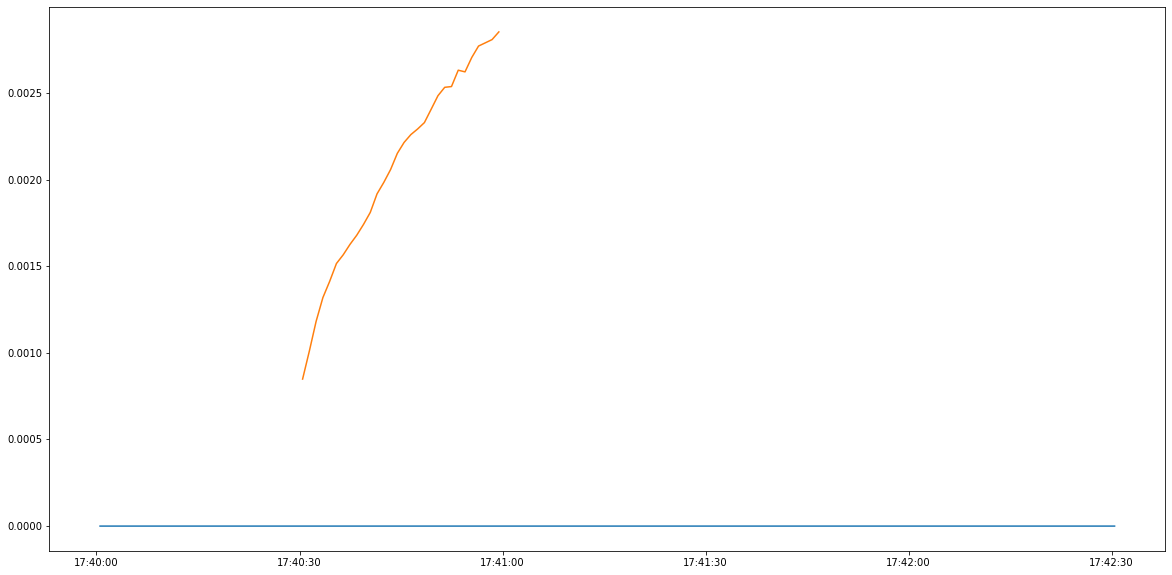

In [96]:
plt.figure(figsize=(20,10))
plt.plot(sub_period.Time, [0 for _ in sub_period.Time])
plt.plot([sig[0] for sig in signa], [sig[1] for sig in signa])

# Plot toxic signatures

In [97]:
buy_sign = np.load(TOXIC_BUY_SIGNATURE_PATH)
sell_sign = np.load(TOXIC_SELL_SIGNATURE_PATH)

In [98]:
x = np.linspace(start=0, stop=90, num=270)
x

array([ 0.        ,  0.33457249,  0.66914498,  1.00371747,  1.33828996,
        1.67286245,  2.00743494,  2.34200743,  2.67657993,  3.01115242,
        3.34572491,  3.6802974 ,  4.01486989,  4.34944238,  4.68401487,
        5.01858736,  5.35315985,  5.68773234,  6.02230483,  6.35687732,
        6.69144981,  7.0260223 ,  7.3605948 ,  7.69516729,  8.02973978,
        8.36431227,  8.69888476,  9.03345725,  9.36802974,  9.70260223,
       10.03717472, 10.37174721, 10.7063197 , 11.04089219, 11.37546468,
       11.71003717, 12.04460967, 12.37918216, 12.71375465, 13.04832714,
       13.38289963, 13.71747212, 14.05204461, 14.3866171 , 14.72118959,
       15.05576208, 15.39033457, 15.72490706, 16.05947955, 16.39405204,
       16.72862454, 17.06319703, 17.39776952, 17.73234201, 18.0669145 ,
       18.40148699, 18.73605948, 19.07063197, 19.40520446, 19.73977695,
       20.07434944, 20.40892193, 20.74349442, 21.07806691, 21.41263941,
       21.7472119 , 22.08178439, 22.41635688, 22.75092937, 23.08

In [16]:
buy_sign

array([0.        , 0.00060652, 0.00076583, 0.00084845, 0.00092663,
       0.00097044, 0.00101048, 0.00105958, 0.00112067, 0.00118184,
       0.00122941, 0.00128676, 0.00131879, 0.00137308, 0.00138769,
       0.00141246, 0.00144499, 0.00147672, 0.00151539, 0.00154786,
       0.00155572, 0.00156564, 0.00157389, 0.00160786, 0.00162569,
       0.00163014, 0.00164679, 0.00167861, 0.00171992, 0.0017324 ,
       0.00174107, 0.00175855, 0.00178216, 0.00181039, 0.00186252,
       0.00188851, 0.00191741, 0.00190683, 0.00193289, 0.00198366,
       0.00200462, 0.00202701, 0.00205765, 0.00209319, 0.00213083,
       0.00215138, 0.00216443, 0.00218651, 0.00221448, 0.00221694,
       0.00222681, 0.00225959, 0.00225123, 0.00227095, 0.00229199,
       0.00229888, 0.00232601, 0.00232881, 0.00234191, 0.00235477,
       0.00240601, 0.0024529 , 0.00246497, 0.00248385, 0.00249143,
       0.00251261, 0.0025324 , 0.00254368, 0.00254669, 0.00253681,
       0.00257654, 0.00262445, 0.00263123, 0.00263597, 0.00262

In [17]:
sell_sign

array([ 0.        , -0.00075791, -0.00087803, -0.00103321, -0.00113821,
       -0.00122333, -0.00126052, -0.00133974, -0.00138549, -0.00144338,
       -0.00151592, -0.00156687, -0.00159671, -0.00161777, -0.00166441,
       -0.00169068, -0.00174871, -0.00180644, -0.00183257, -0.00188105,
       -0.00195594, -0.0020072 , -0.0020207 , -0.002052  , -0.00211205,
       -0.0021449 , -0.00217915, -0.00225794, -0.00230171, -0.00232768,
       -0.00236021, -0.00238682, -0.00237972, -0.00244329, -0.00247361,
       -0.00249195, -0.0025295 , -0.00255341, -0.00259696, -0.00264395,
       -0.00273695, -0.00278872, -0.00282395, -0.00288957, -0.00285522,
       -0.0029191 , -0.00296304, -0.00296922, -0.00298147, -0.00301119,
       -0.00302765, -0.00300586, -0.00299598, -0.00301399, -0.00300877,
       -0.00303986, -0.00304696, -0.00307504, -0.00311531, -0.00312492,
       -0.00312307, -0.00314031, -0.00315478, -0.00319003, -0.00320025,
       -0.00320317, -0.00323405, -0.00326066, -0.00330097, -0.00

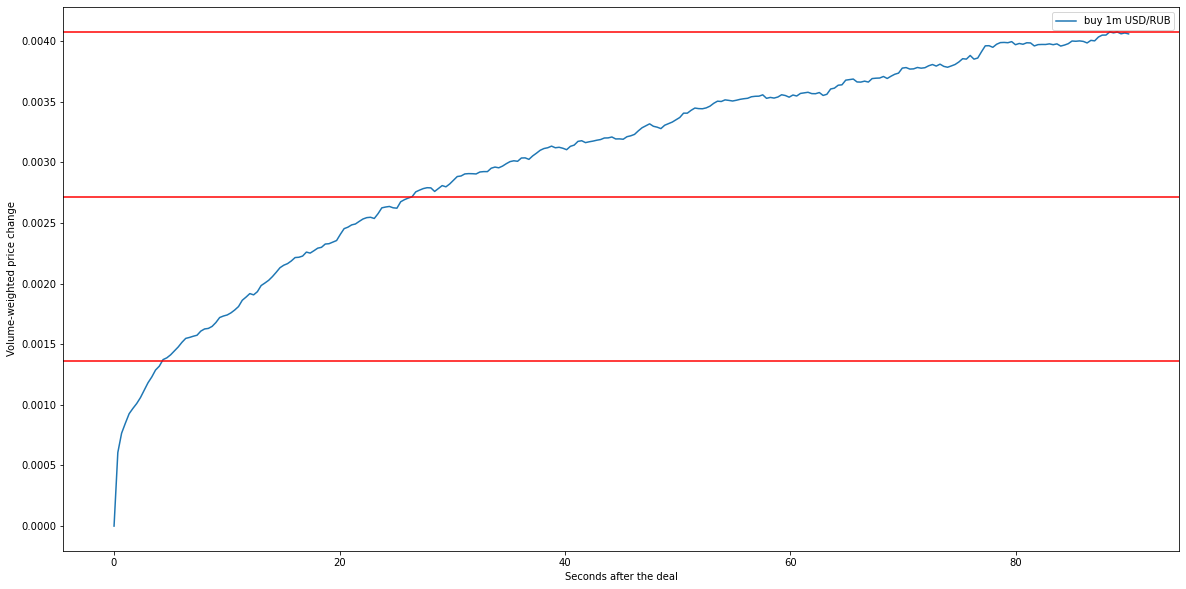

In [99]:
plt.figure(figsize=(20,10))
plt.plot(x, buy_sign, label = 'buy 1m USD/RUB')
plt.xlabel("Seconds after the deal")
plt.ylabel("Volume-weighted price change")
plt.legend()
plt.axhline(y=buy_sign.max(), color='r', linestyle='-')
plt.axhline(y=2/3 * buy_sign.max(), color='r', linestyle='-')
plt.axhline(y=1/3 * buy_sign.max(), color='r', linestyle='-')
plt.savefig('buy1m.png', bbox_inches='tight')

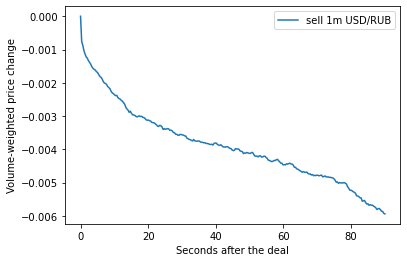

In [100]:
plt.plot(x, sell_sign, label = 'sell 1m USD/RUB')
plt.xlabel("Seconds after the deal")
plt.ylabel("Volume-weighted price change")
plt.legend()
plt.savefig('sell1m.png', bbox_inches='tight')

In [101]:
pd.read_feather('../VWAP_1_sec/VWAP_1_sec_02.feather').dropna().head(100)

,Time,100k.BID_VALUE,100k.ASK_VALUE,1m.BID_VALUE,1m.ASK_VALUE,5m.BID_VALUE,5m.ASK_VALUE
36000,2021-02-01 10:00:02,75.567500,75.595000,75.543615,75.599500,75.261701,75.600000
36001,2021-02-01 10:00:03,75.574500,75.597025,75.554457,75.599703,75.400023,75.599900
36002,2021-02-01 10:00:04,75.573750,75.600000,75.559462,75.600000,75.505729,75.599941
36003,2021-02-01 10:00:05,75.557825,75.586250,75.528045,75.596895,75.516724,75.600000
36004,2021-02-01 10:00:06,75.537500,75.579525,75.530315,75.590915,75.471992,75.599379
...,...,...,...,...,...,...,...
36095,2021-02-01 10:01:37,75.557500,75.570000,75.551135,75.572552,75.548609,75.586393
36096,2021-02-01 10:01:38,75.557500,75.570000,75.551135,75.572177,75.548481,75.586669
36097,2021-02-01 10:01:39,75.557500,75.570000,75.551635,75.573795,75.548508,75.586344
36098,2021-02-01 10:01:40,75.557500,75.570000,75.551135,75.573012,75.549061,75.587789


In [102]:
chart1 = np.pad(sell_sign, pad_width=(110, 90), mode='edge')
chart2 = np.pad(buy_sign, pad_width=(100, 100), mode='edge')
chart3 = np.pad(buy_sign, pad_width=(120, 80), mode='edge')
chart4 = np.pad(buy_sign, pad_width=(150, 50), mode='edge')
print(len(chart1))
print(len(chart2))
print(len(chart3))
print(len(chart4))
summ_chart = chart1 + chart2 + chart3 + chart4

470
470
470
470


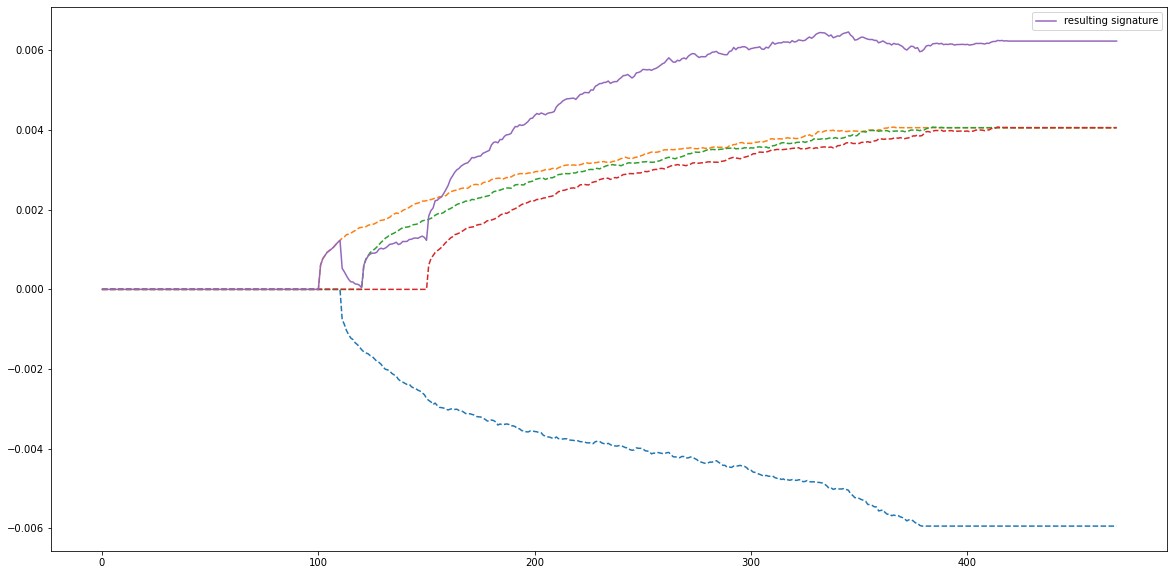

In [103]:
plt.figure(figsize=(20,10))
plt.plot(chart1, linestyle='dashed')
plt.plot(chart2, linestyle='dashed')
plt.plot(chart3, linestyle='dashed')
plt.plot(chart4, linestyle='dashed')
plt.plot(summ_chart, label = 'resulting signature')
plt.legend()
plt.savefig('resulting_signature1.png')

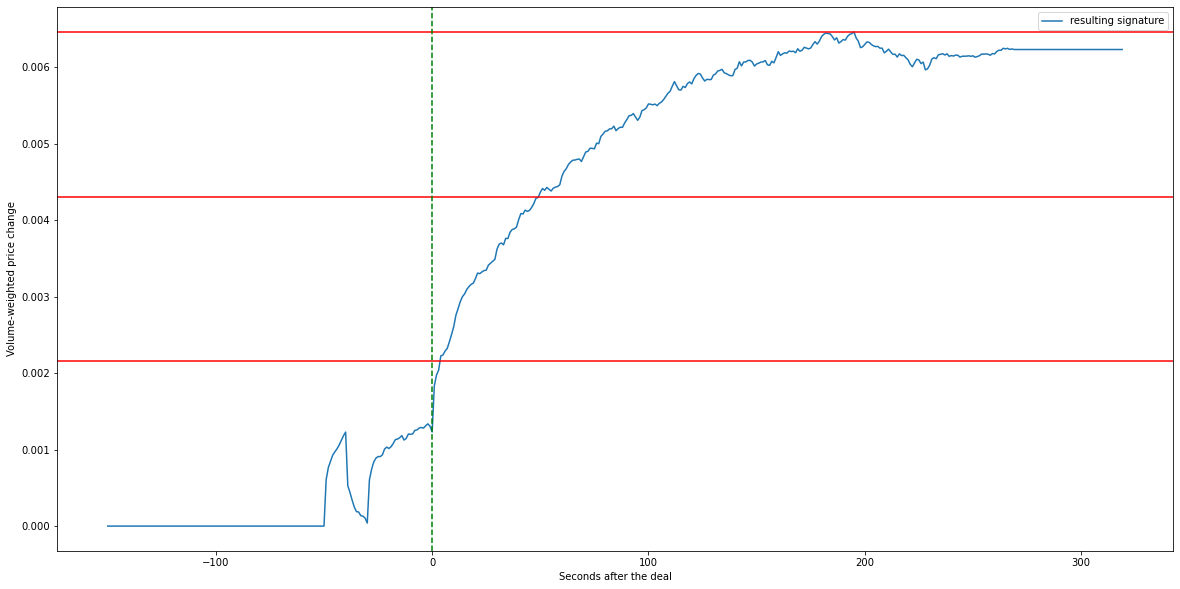

In [104]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(-150, 320)], summ_chart, label = 'resulting signature')
plt.xlabel("Seconds after the deal")
plt.ylabel("Volume-weighted price change")
plt.legend()
plt.axhline(y=summ_chart.max(), color='r', linestyle='-')
plt.axhline(y=2/3 * summ_chart.max(), color='r', linestyle='-')
plt.axhline(y=1/3 * summ_chart.max(), color='r', linestyle='-')
plt.axvline(x=0, color='g', linestyle='dashed')
plt.savefig('resulting_signature2.png')